## Pytorch tutorial

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 


In [2]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print("MPS is available!")
    mps_device = torch.device("mps")

MPS is available!


### 1. Tensors

In [3]:
# create tensor from data
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

# create tensor form numpy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# retain properties from the original tensor
x_ones = torch.ones_like(x_data)
print(f"Ones Tensor: \n {x_ones} \n")

# override dtype
x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.2952, 0.0262],
        [0.4571, 0.4476]]) 



In [6]:
#determine dimensionality of tensor
shape = (2,3)
rand_tensor = torch.rand(shape, device=mps_device)
print(f"Shape of tensor: {rand_tensor.shape}")
print(f"Datatype of tensor: {rand_tensor.dtype}")
print(f"Device tensor is stored on: {rand_tensor.device}")

#print(torch.backends.mps.is_available())
#rand_tensor.to('cpu')
#print(f"Device tensor is stored on: {rand_tensor.device}")

Shape of tensor: torch.Size([2, 3])
Datatype of tensor: torch.float32
Device tensor is stored on: mps:0


In [7]:
test_ones = torch.rand_like(rand_tensor, device='cpu')
C = test_ones * rand_tensor

print(C)

print(f"Device tensor is stored on: {test_ones.device}")
print(test_ones)
test_ones.to(mps_device)
print(test_ones)
print(f"Device tensor is stored on: {test_ones.device}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [12]:
#concatinate tensors
t1 = torch.cat([rand_tensor, rand_tensor, rand_tensor], dim=1)

#element wise product
t2 = rand_tensor.mul(rand_tensor)
t3 = rand_tensor * rand_tensor
print(t2)
print(t3)

#matrix multiplication
t4 = rand_tensor.matmul(t2.T)
t5 = rand_tensor @ t2.T
print(t4)
print(t5)

#inplace operations
t5.add_(1)
print(t5)

tensor([[0.0264, 0.2462, 0.5204],
        [0.0393, 0.1501, 0.0578]], device='mps:0')
tensor([[0.0264, 0.2462, 0.5204],
        [0.0393, 0.1501, 0.0578]], device='mps:0')
tensor([[0.5019, 0.1226],
        [0.2258, 0.0799]], device='mps:0')
tensor([[0.5019, 0.1226],
        [0.2258, 0.0799]], device='mps:0')
tensor([[1.5019, 1.1226],
        [1.2258, 1.0799]], device='mps:0')


In-place operations save some memory, but can be problematic when computing derivatives because of an immediate loss of history. Hence, their use is discouraged.

#### Bridge to Numpy

In [13]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [14]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


other way around numpy to tensor

In [15]:
n = np.ones(5)
t = torch.from_numpy(n)
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


### 2. Autograd

In [16]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/johannes/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.64MB/s]


Next, we run the input data through the model through each of its layers to make a prediction. This is the forward pass.

In [17]:
prediction = model(data) # forward pass

We use the model’s prediction and the corresponding label to calculate the error (loss). The next step is to backpropagate this error through the network. Backward propagation is kicked off when we call .backward() on the error tensor. Autograd then calculates and stores the gradients for each model parameter in the parameter’s .grad attribute.

In [18]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

Next, we load an optimizer, in this case SGD with a learning rate of 0.01 and momentum of 0.9. We register all the parameters of the model in the optimizer.

In [20]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
optim.step() #gradient descent

#### Differentiation in AutoGrad

requires_grad signalizes that of every operation should be kept track

In [32]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

Create another tensor
$$
    Q = 3a^3 - b^2
$$

In [33]:
Q = 3*a**3 - b**2

Let’s assume a and b to be parameters of an NN, and Q to be the error. In NN training, we want gradients of the error w.r.t. parameters, i.e.
$$
    \frac{\partial Q}{\partial a} = 9 a^2
$$
$$
    \frac{\partial Q}{\partial b} = -2b
$$

When we call .backward() on Q, autograd calculates these gradients and stores them in the respective tensors’ .grad attribute.

We need to explicitly pass a gradient argument in Q.backward() because it is a vector. gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.

In [34]:
Q.backward(gradient=torch.tensor([1., 1.]))
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)


tensor([True, True])
tensor([True, True])


### 3. Neural Networks

In [158]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(Net, self).__init__() # same as super().__init__() -> allows to access methods of parent class
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 50, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(50, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Parameters are 10: 5 weights and 5 bias

In [155]:
params = list(net.parameters())
print(params)
print(len(params))
print(params[0].size())  # conv1's .weight

[Parameter containing:
tensor([[[[-6.5615e-02, -1.0326e-02,  5.5221e-02, -2.9643e-02,  3.2259e-02],
          [-6.7822e-03, -8.0203e-02,  5.9750e-02,  2.2924e-02,  1.2281e-02],
          [-7.4020e-03, -9.1612e-02, -9.4269e-03, -7.7228e-02, -7.7851e-02],
          [-5.5704e-02, -4.5303e-02, -2.1047e-02,  5.3509e-02,  6.2458e-02],
          [-7.9431e-02, -1.0128e-01, -6.5948e-02, -1.1138e-01, -1.0081e-01]],

         [[ 2.5288e-02, -6.1744e-02, -1.0713e-01,  5.2738e-02,  1.1016e-02],
          [ 7.8119e-02,  8.2717e-02,  6.4527e-02,  1.1266e-01,  9.2925e-02],
          [ 8.4544e-02,  4.1511e-02, -4.3447e-02,  1.1535e-01,  1.1394e-01],
          [ 6.2832e-02, -5.8643e-02,  9.6707e-02,  1.0454e-01,  2.9112e-02],
          [ 7.5918e-02,  1.4665e-02,  3.4601e-02,  2.7798e-02,  9.1383e-02]],

         [[ 7.9590e-02, -2.6814e-02, -4.0847e-02,  1.3517e-02,  3.5159e-02],
          [-1.4380e-02,  1.2375e-02,  6.6631e-02, -4.4050e-02,  3.7586e-02],
          [ 6.3945e-02, -1.0653e-01, -9.2103e-02,

In [49]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0392, -0.0588, -0.1414,  0.0110, -0.0025, -0.0452, -0.0219, -0.0486,
         -0.0481, -0.0667]], grad_fn=<AddmmBackward0>)


In [50]:
net.zero_grad()
out.backward(torch.randn(1, 10))

Compute Loss with MSE

In [52]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
print(loss.grad_fn)  # MSELoss

tensor(0.7220, grad_fn=<MseLossBackward0>)


In [58]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backpropagate

In [59]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-1.0127e-02, -4.1697e-03, -5.2998e-03, -1.1979e-03,  3.5369e-06,
        -6.0802e-03])


Update the weights using SGD:

In [61]:
# weight = weight - learning_rate * gradient
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)


In [122]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
while loss.item() > 1E-10:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    print(loss)
    loss.backward()
    optimizer.step()    # Does the update
    print(loss)

tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.00

### 4. Training an image classifier

In [123]:
import torch
import torchvision
import torchvision.transforms as transforms

In [124]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:30<00:00, 5557025.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


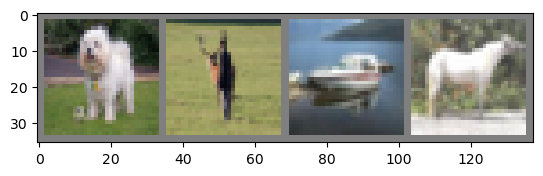

dog   deer  ship  horse


In [126]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [159]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


#### Training the network

In [160]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.115
[1,  4000] loss: 1.731
[1,  6000] loss: 1.565
[1,  8000] loss: 1.484
[1, 10000] loss: 1.407
[1, 12000] loss: 1.390
Finished Training


In [161]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 5. Validation

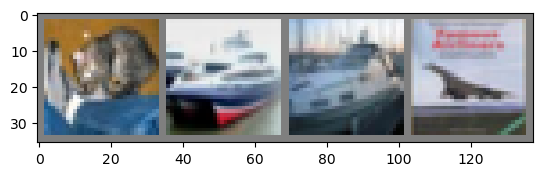

GroundTruth:  cat   ship  ship  plane


In [137]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [162]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [139]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   car   car   ship 


In [163]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

In [141]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.9 %
Accuracy for class: car   is 78.5 %
Accuracy for class: bird  is 38.8 %
Accuracy for class: cat   is 14.7 %
Accuracy for class: deer  is 44.6 %
Accuracy for class: dog   is 47.9 %
Accuracy for class: frog  is 78.2 %
Accuracy for class: horse is 55.4 %
Accuracy for class: ship  is 57.2 %
Accuracy for class: truck is 66.3 %


In [164]:
device = torch.device('mps')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        #move to gpu
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

mps
[1,  2000] loss: 1.238
[1,  4000] loss: 1.259
[1,  6000] loss: 1.266
[1,  8000] loss: 1.255
[1, 10000] loss: 1.247
[1, 12000] loss: 1.249
Finished Training
